# Plotting POL-2 data




packages I use:

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.visualization import ImageNormalize, SqrtStretch
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxesSubplot
from astropy.coordinates import SkyCoord


from astropy.table import Table, Column
import astropy.units as u
import numpy as np
import aplpy

/local/python/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


For jupyter notebook I need plotting to be "inline"

In [2]:
%matplotlib inline

# input files

In [3]:
# ndf files neede for this jupyter notebook:

pol2path = '/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/pixel4asec/'
sc2path = '/export/data2/hparsons/FOP/JellyFish/SCUBA2/Reduced/'

ndfi = pol2path + 'iext.sdf' # absolute file path
ndfiauto = pol2path + 'iauto.sdf' # absolute file path
ndfisnr = pol2path + 'iext_snr.sdf' # absolute file path
vectorcat = pol2path + 'selcat.FIT' # absolute file path

ndf850 = sc2path + '850um_corr_map_mJybeam.sdf' # absolute file path

In [4]:
def convert_ndf_to_fits(ndfin):
    '''
    Function takes input ndf and either reports exsiting 
    fits file of the same name or produces a new fits file
    containing the same data. required information = ndf file name
    note fits file goes in same directory as ndf file provided
    '''
    from starlink import convert
    from pathlib import Path
    fitsextension = '.fits'
    filename = ndfin[:-4]
    fitsout = filename+fitsextension
    if Path(fitsout).is_file():
        print("file exists: {}".format(fitsout))
    else:
        convert.ndf2fits(ndfin,fitsout)
        print("file produced: {}".format(fitsout))
    return fitsout


In [5]:
# checking to see if files have fits formats avaliable and if not producing them:

ifits = convert_ndf_to_fits(ndfi)
ifitsauto = convert_ndf_to_fits(ndfiauto)
ifitssnr = convert_ndf_to_fits(ndfisnr)
fits850 = convert_ndf_to_fits(ndf850)

file exists: /export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/pixel4asec/iext.fits
file exists: /export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/pixel4asec/iauto.fits
file exists: /export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/pixel4asec/iext_snr.fits
file exists: /export/data2/hparsons/FOP/JellyFish/SCUBA2/Reduced/850um_corr_map_mJybeam.fits


In [6]:
hdumain = fits.open(ifits)[0]
wcs = WCS(hdumain.header)
wcs = wcs.dropaxis(2)
data = hdumain.data[0,:,:]

In [7]:
vectors = Table.read(vectorcat)

# If needed make additional cut to vectors

I run:

catselect catin=mycat.FIT catout=selcat.FIT norejcat seltyp=e "expr='i>10*di and p>3*dp and pi/dpi>3 and P<100'"

so not needed

In [8]:
# i_snr = 10.0
# p_snr = 5.0


# condition = (vectors['I']/vectors['DI'] > i_snr)
# condition &= (vectors['PI']/vectors['DPI'] > p_snr)
# chosenvec = vectors[condition]


# The vector catalogue

In [9]:
vectors.show_in_notebook()

idx,X,Y,RA,DEC,I,DI,Q,DQ,U,DU,P,DP,ANG,DANG,PI,DPI
,pix,pix,RADIANS{HOURS},RADIANS{DEGREES},mJy / beam,mJy / beam,mJy / beam,mJy / beam,mJy / beam,mJy / beam,%,%,Degrees,Degrees,mJy / beam,mJy / beam
0,-0.5,-21.5,4.671439551425891,-0.5052702739560346,88.26748,3.3905694,0.2612957,2.031523,7.032238,1.888741,7.679872,2.161825,43.936024,8.269526,6.7788296,1.8889455
1,-2.5,-19.5,4.671393430160055,-0.5051107476878788,95.10101,2.2215354,9.06606,2.0605428,3.9075236,1.490282,10.1694765,2.0982354,11.658159,4.6231146,9.671275,1.9820722
2,-0.5,-19.5,4.671325339506081,-0.505210689258371,104.0364,3.3815715,3.425367,1.9788713,-4.071297,1.0683577,4.9028125,1.4644595,-24.962286,8.954808,5.10071,1.5137241
3,-2.5,-18.5,4.67133632905067,-0.5050809549017148,126.249275,3.0049608,5.820611,1.2652732,-1.6057298,1.872494,4.667398,1.0497181,-7.7112813,8.711794,5.892556,1.3174459
4,-0.5,-18.5,4.671268236357513,-0.5051808948317585,35.769505,2.0320485,-3.6266103,1.2025325,-1.8467221,1.3706528,10.837542,3.5236785,-76.50707,9.416873,3.876535,1.2390162
5,-4.5,-17.5,4.671347317019737,-0.5049512204823615,69.428825,2.411225,-5.121838,1.6462108,-3.8944068,1.9511874,8.912301,2.5611312,-71.37616,8.216113,6.1877055,1.7640668
6,-1.5,-17.5,4.671245183390351,-0.5051011301208937,37.096146,2.065338,6.7295227,1.4705163,-0.2619003,1.2095829,17.716642,4.0899606,-1.1143593,5.1472144,6.5721917,1.4701567
7,0.5,-17.5,4.671177084894765,-0.5052010674292422,42.1031,1.9849554,-4.8533006,1.7700459,3.9482424,1.9163166,14.210168,4.401865,70.43553,8.514278,5.982921,1.8296993
8,1.5,-17.5,4.6711430328239425,-0.5052510353469446,27.669018,2.1038926,-5.370684,1.4187273,-0.6292718,1.5981703,18.856073,5.347451,-86.658615,8.454756,5.21729,1.4213088


Reminder of the Table headers:
* X 	Pixel coordinate
* Y 	Pixel coordinate
* RA 	RA coordinate
* Dec 	Dec coordinate
* I 	Total intensity
* DI 	Error in I
* Q 	Stokes Q parameter
* DQ 	Error in Q
* U 	Stokes U parameter
* DU 	Error in U
* P 	Percentage polarisation
* DP 	Error in P
* ANG 	Angle of polarisation
* DANG 	Error in ANG
* PI 	Polarised intensity (Ip)
* DPI 	Error in polarised intensity

# Converting Coordinates

Converting the coordinates from RA and Dec in radians to galactic coordinates

Then add these new coordiantes to the table


In [10]:
ldeg = []
bdeg = []

for x in range(len(vectors['X'])):
    rarad = vectors['RA'][x]*u.radian
    decrad = vectors['DEC'][x]*u.radian
    c = SkyCoord(rarad, decrad).galactic
    l = c.l.deg
    b = c.b.deg
    ldeg.append(l)
    bdeg.append(b)
    
ldeg = Column(ldeg, name='ldeg')
bdeg = Column(bdeg, name='bdeg')

try:
    if vectors['ldeg'].any:
        print ('column exists')
except:
    print ('column does not exist')
    vectors.add_columns([ldeg])
    print ('added tdata[ldeg]')

try:
    if vectors['bdeg'].any:
        print ('column exists')
except:
    print ('column does not exist')
    vectors.add_columns([bdeg])
    print ('added tdata[bdeg]')


column does not exist
added tdata[ldeg]
column does not exist
added tdata[bdeg]


In [11]:
vectors.show_in_notebook()

idx,X,Y,RA,DEC,I,DI,Q,DQ,U,DU,P,DP,ANG,DANG,PI,DPI,ldeg,bdeg
,pix,pix,RADIANS{HOURS},RADIANS{DEGREES},mJy / beam,mJy / beam,mJy / beam,mJy / beam,mJy / beam,mJy / beam,%,%,Degrees,Degrees,mJy / beam,mJy / beam,,
0,-0.5,-21.5,4.671439551425891,-0.5052702739560346,88.26748,3.3905694,0.2612957,2.031523,7.032238,1.888741,7.679872,2.161825,43.936024,8.269526,6.7788296,1.8889455,0.5527966867610667,-0.9427913884806913
1,-2.5,-19.5,4.671393430160055,-0.5051107476878788,95.10101,2.2215354,9.06606,2.0605428,3.9075236,1.490282,10.1694765,2.0982354,11.658159,4.6231146,9.671275,1.9820722,0.5594642990269093,-0.9361246608348606
2,-0.5,-19.5,4.671325339506081,-0.505210689258371,104.0364,3.3815715,3.425367,1.9788713,-4.071297,1.0683577,4.9028125,1.4644595,-24.962286,8.954808,5.10071,1.5137241,0.5527966819097359,-0.9361246723958817
3,-2.5,-18.5,4.67133632905067,-0.5050809549017148,126.249275,3.0049608,5.820611,1.2652732,-1.6057298,1.872494,4.667398,1.0497181,-7.7112813,8.711794,5.892556,1.3174459,0.5594642907104538,-0.9327913021512505
4,-0.5,-18.5,4.671268236357513,-0.5051808948317585,35.769505,2.0320485,-3.6266103,1.2025325,-1.8467221,1.3706528,10.837542,3.5236785,-76.50707,9.416873,3.876535,1.2390162,0.552796679484078,-0.9327913136708746
5,-4.5,-17.5,4.671347317019737,-0.5049512204823615,69.428825,2.411225,-5.121838,1.6462108,-3.8944068,1.9511874,8.912301,2.5611312,-71.37616,8.216113,6.1877055,1.7640668,0.5661318874737339,-0.9294579189795275
6,-1.5,-17.5,4.671245183390351,-0.5051011301208937,37.096146,2.065338,6.7295227,1.4705163,-0.2619003,1.2095829,17.716642,4.0899606,-1.1143593,5.1472144,6.5721917,1.4701567,0.5561304797468813,-0.9294579503548802
7,0.5,-17.5,4.671177084894765,-0.5052010674292422,42.1031,1.9849554,-4.8533006,1.7700459,3.9482424,1.9163166,14.210168,4.401865,70.43553,8.514278,5.982921,1.8296993,0.5494628743511007,-0.9294579555407047
8,1.5,-17.5,4.6711430328239425,-0.5052510353469446,27.669018,2.1038926,-5.370684,1.4187273,-0.6292718,1.5981703,18.856073,5.347451,-86.658615,8.454756,5.21729,1.4213088,0.546129071647583,-0.9294579534143402


# Plotting vectors

Need to not use aplpy to plot my figues as I need to use quiver

In [12]:
# Set up arrows.
X, Y = wcs.wcs_world2pix(vectors['ldeg'], vectors['bdeg'], 1)
U = vectors['P'] * np.sin(np.deg2rad(90 - vectors['ANG']))
V = vectors['P'] * np.cos(np.deg2rad(90 - vectors['ANG']))

INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmax to  3.208e-03 [aplpy.core]


/local/python/lib/python3.5/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


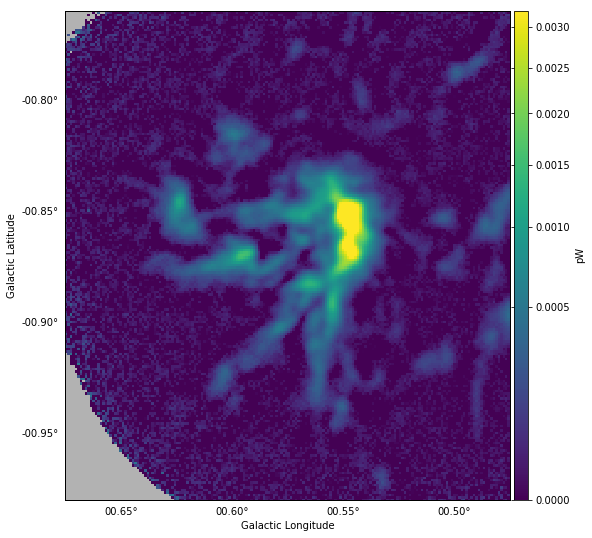

In [13]:
figpoli = aplpy.FITSFigure(ifits)

figpoli.show_colorscale(0,0.00175,stretch='sqrt',cmap='viridis') # magma or plasma also options: https://matplotlib.org/examples/color/colormaps_reference.html

figpoli.set_nan_color('0.7')

figpoli.add_colorbar()

figpoli.colorbar.set_axis_label_text('pW')

figpoli.recenter(0.575, -0.87, width=0.2, height=0.22)

figpoli.tick_labels.set_xformat('ddd.dd')
figpoli.tick_labels.set_yformat('ddd.dd')

#figpoli.show_vectors()

# need to get axis ax poli_ax1?!?!?!?!

In [ ]:
quiv = ax.quiver(X, Y, U, V, color='white',
                 headaxislength=0, headlength=0, pivot='middle', headwidth=1) 

## Plotting image using Aplpy

I find it easier to use aplpy to plot my intensity pol2 image. However what I find is wen I overplot the SCUBA-2 data I do not return the same strucutre in my final image. 

> show_lines

In [ ]:
figpoli = aplpy.FITSFigure(ifits)

figpoli.show_colorscale(0,0.00175,stretch='sqrt',cmap='viridis') # magma or plasma also options: https://matplotlib.org/examples/color/colormaps_reference.html

figpoli.set_nan_color('0.7')

figpoli.add_colorbar()

figpoli.colorbar.set_axis_label_text('pW')

figpoli.recenter(0.575, -0.87, width=0.2, height=0.22)

figpoli.tick_labels.set_xformat('ddd.dd')
figpoli.tick_labels.set_yformat('ddd.dd')

figpoli.show_contour(fits850, levels=[0.5,1,2,4], colors='orange') # plotting 850um SCUBA-2 over the top
figpoli.show_contour(ifitssnr, levels=[10],colors='white')


figpoli.savefig('/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/images/Jellyfish-pol2-contours.pdf')
figpoli.savefig('/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/images/Jellyfish-pol2-contours.png')

#figpoli.show_lines # how I hope to overplot my 

### Visual inspection of various POL-2 reductions (the total intesnsity maps)

In [ ]:
def explore_pol2_plot(iauto,iext,astmask,pcamask,outname):
    '''
    This function will take four fits maps - the iauto, 
    iext the ast mask and the pca mask and visulise them
    it will produce an output image saved under outname
    '''
    
    fig = plt.figure(figsize=(14,14))

    fa = aplpy.FITSFigure(iauto, figure=fig, subplot=[0.1,0.5,0.35,0.35])
    fa.recenter(0.575, -0.87, width=0.16, height=0.22)
    fa.show_colorscale(0,0.00175,stretch='sqrt',cmap='viridis')
    fa.set_title(iauto)
    fa.tick_labels.set_xformat('ddd.dd')
    fa.tick_labels.set_yformat('ddd.dd')

    fe = aplpy.FITSFigure(iext, figure=fig, subplot=[0.5,0.5,0.35,0.35])
    fe.recenter(0.575, -0.87, width=0.16, height=0.22)
    fe.show_colorscale(0,0.00175,stretch='sqrt',cmap='viridis')
    fe.add_colorbar()
    fe.set_title("externally masked")
    fe.colorbar.set_axis_label_text('pW')
    fe.tick_labels.set_xformat('ddd.dd')

    fe.hide_yaxis_label()
    fe.hide_ytick_labels()
    
    fm = aplpy.FITSFigure(astmask, figure=fig, subplot=[0.1,0.1,0.35,0.35])
    fm.set_title("The ast mask")
    fm.recenter(0.575, -0.87, width=0.16, height=0.22)
    fm.show_colorscale(cmap='plasma')
    fm.tick_labels.set_xformat('ddd.dd')
    fm.tick_labels.set_yformat('ddd.dd')
    
    fp = aplpy.FITSFigure(pcamask, figure=fig, subplot=[0.5,0.1,0.35,0.35])
    fp.set_title("The pca mask")
    fp.recenter(0.575, -0.87, width=0.16, height=0.22)
    fp.show_colorscale(cmap='magma')
    fp.tick_labels.set_xformat('ddd.dd')
    
    fp.hide_yaxis_label()
    fp.hide_ytick_labels()
    
    fig.savefig(outname)


In [ ]:
# files to plot REDUCTION

ndfi = '/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/pixel12asec/iext.sdf' # absolute file path
ndfiauto = '/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/pixel12asec/iauto.sdf' # absolute file path
ndfastmask = '/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/pixel12asec/astmask.sdf' # absolute file path
ndfpcamask = '/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/pixel12asec/pcamask.sdf' # absolute file path

outname = '/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/images/reduction1.pdf'

# quick fits check

fitsi = convert_ndf_to_fits(ndfi)
fitsiauto = convert_ndf_to_fits(ndfiauto)
fitsastmask = convert_ndf_to_fits(ndfastmask)
fitspcamask = convert_ndf_to_fits(ndfpcamask)

# produce the plots

explore_pol2_plot(fitsiauto,fitsi,fitsastmask,fitspcamask,outname)